In [1]:
import pandas as pd

X_train = pd.read_csv('dog_data/X_train_data.csv')
X_test = pd.read_csv('dog_data/X_test_data.csv')
y_train = pd.read_csv('dog_data/y_train_data.csv')
y_test = pd.read_csv('dog_data/y_test_data.csv')

In [3]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, recall_score, roc_auc_score
def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average='weighted')
    recall = recall_score(y_test, pred, average='weighted')
    f1 = f1_score(y_test, pred, average='weighted')
    roc_auc = roc_auc_score(y_test, pred_proba, average='weighted', multi_class='ovr')
    print('정확도: {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}, F1:{3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))  

In [80]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
param_grid = {
    'num_leaves': [31, 42, 127],
    'learning_rate': [0.01, 0.05, 0.1, 0.005],
    'n_estimators': [500,],
    'max_depth': [-1, 10, 27],
}

model = XGBClassifier(n_estimators=10000, learning_rate=0.001, objective='multi:softproba')
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
# xgb_model = model.fit(X_train, y_train, early_stopping_rounds = 300, eval_metric='mlogloss', eval_set=[(X_train, y_train), (X_test, y_test)], verbose=True)

# y_pred = model.predict(X_test)
y_pred = best_model.predict(X_test)
x_pred_proba = best_model.predict_proba(X_test)
# x_pred_proba = xgb_model.predict_proba(X_test)
get_clf_eval(y_test, y_pred, x_pred_proba)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


c:\Users\Admin\Desktop\metaverse\project\dog_adopt_probability\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Admin\Desktop\metaverse\project\dog_adopt_probability\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Admin\Desktop\metaverse\project\dog_adopt_probability\.venv\Lib\site-packages\xgboost\core.py", line 575, in inner_f
    return f(**kwargs)
           ^^^^^^^^^^^
  File "c:\Users\Admin\Desktop\metaverse\

[19:58:27] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


정확도: 0.6760, 정밀도 : 0.6685, 재현율 : 0.6760, F1:0.6713, AUC:0.8276


dict_keys(['validation_0', 'validation_1'])


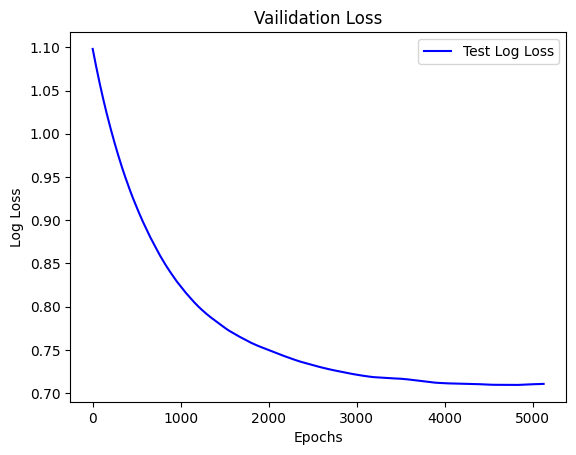

In [78]:
import matplotlib.pyplot as plt
results = xgb_model.evals_result()
print(results.keys())
# train_loss = results['validation_0']['mlogloss']
test_loss = results['validation_1']['mlogloss']

epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test Log Loss', color = 'b')
# ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train Log Loss', color = 'r')
ax.legend()
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('Vailidation Loss')
plt.show()

In [74]:
import lightgbm as lgb

initial_learning_rate = 0.1
param_grid = {
    'num_leaves': [31, 42, 127],
    'learning_rate': [0.01, 0.05],
    'n_estimators': [500, 1000],
    'max_depth': [-1, 10, 30],
    'min_data_in_leaf':[10, 27, 40]
}

def learning_rate_decay(current_round, num_round, init_rate):
    decay_rate = 0.95  # 매 라운드마다 95%로 학습률 감소
    new_learning_rate = init_rate * (decay_rate ** current_round)
    return new_learning_rate

# LightGBM 콜백으로 학습률 조정
def reset_learning_rate_callback(env):
    new_lr = learning_rate_decay(env.iteration, env.end_iteration, initial_learning_rate)
    env.model.reset_parameter({"learning_rate": new_lr})

model = lgb.LGBMClassifier(
    boosting_type='gbdt',
    num_leaves=42,
    learning_rate=0.005,
    n_estimators=2000,
    max_depth=-1,
    min_data_in_leaf=10,
    objective='multiclass',
    metric='multi_logloss',
    num_class=3,
    verbose=1
    )

lgb_model = model.fit(X_train, y_train, eval_metric='multi_logloss', callbacks=[
        lgb.early_stopping(stopping_rounds=100),
    ], eval_set=[(X_train, y_train), (X_test, y_test)])

y_pred = lgb_model.predict(X_test)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# 학습 및 최적의 파라미터 찾기
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 성능 출력
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy: ", grid_search.best_score_)

# 테스트 데이터에서 최적의 모델로 예측
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
# x_pred_proba = lgb_model.predict_proba(X_test)
get_clf_eval(y_test, y_pred, x_pred_proba)

c:\Users\Admin\Desktop\metaverse\project\dog_adopt_probability\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Admin\Desktop\metaverse\project\dog_adopt_probability\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Users\Admin\Desktop\metaverse\project\dog_adopt_probability\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 1996, number of used features: 10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score -0.714414
[LightGBM] [Info] Start training from score -1.378310
[LightGBM] [Info] Start training from score -1.352794
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[542]	training's multi_logloss: 0.454778	valid_1's multi_logloss: 0.711
[LightGBM] [Warn

KeyboardInterrupt: 

dict_keys(['training', 'valid_1'])


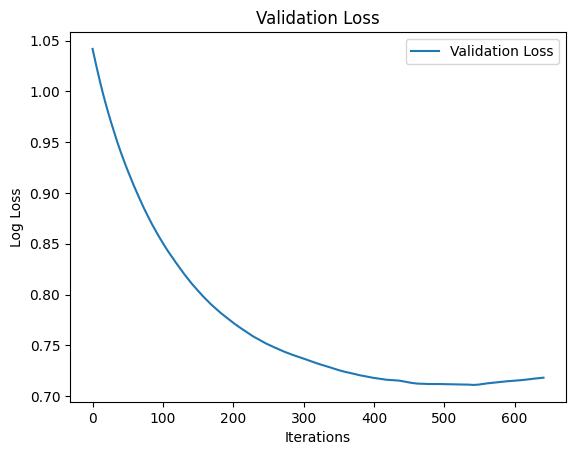

In [75]:
import matplotlib.pyplot as plt
results = lgb_model.evals_result_
print(results.keys())
# train_loss = results['training']['multi_logloss']
test_loss = results['valid_1']['multi_logloss']

# plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('Validation Loss')
plt.legend()
plt.show()

In [221]:
import catboost as cb

model = cb.CatBoostClassifier(
    iterations=300,  # 트리의 개수 (또는 부스팅 반복 횟수)
    learning_rate=0.05,  # 학습률
    depth=12,  # 트리의 깊이
    loss_function='MultiClass',  # 다중 클래스 분류를 위한 손실 함수
    verbose=1  # 학습 과정 출력 제어 (0이면 출력하지 않음)
)

# 모델 학습
cb_model = model.fit(X_train, y_train, eval_set=(X_test, y_test))

y_pred = cb_model.predict(X_test)
x_pred_proba = cb_model.predict_proba(X_test)
get_clf_eval(y_test, y_pred, x_pred_proba)

0:	learn: 1.0700625	test: 1.0720832	best: 1.0720832 (0)	total: 25.5ms	remaining: 7.62s
1:	learn: 1.0476766	test: 1.0539628	best: 1.0539628 (1)	total: 77.2ms	remaining: 11.5s
2:	learn: 1.0235890	test: 1.0312192	best: 1.0312192 (2)	total: 80.5ms	remaining: 7.97s
3:	learn: 1.0036236	test: 1.0156413	best: 1.0156413 (3)	total: 137ms	remaining: 10.1s
4:	learn: 0.9822071	test: 0.9963027	best: 0.9963027 (4)	total: 140ms	remaining: 8.27s
5:	learn: 0.9662721	test: 0.9841582	best: 0.9841582 (5)	total: 189ms	remaining: 9.28s
6:	learn: 0.9488419	test: 0.9674052	best: 0.9674052 (6)	total: 191ms	remaining: 7.99s
7:	learn: 0.9343003	test: 0.9559302	best: 0.9559302 (7)	total: 238ms	remaining: 8.68s
8:	learn: 0.9181441	test: 0.9407122	best: 0.9407122 (8)	total: 240ms	remaining: 7.75s
9:	learn: 0.9051921	test: 0.9299888	best: 0.9299888 (9)	total: 295ms	remaining: 8.55s
10:	learn: 0.8926933	test: 0.9204219	best: 0.9204219 (10)	total: 349ms	remaining: 9.16s
11:	learn: 0.8813503	test: 0.9101860	best: 0.9101

In [2]:
import numpy as np
print(np.__version__)

1.26.0


In [6]:
import pickle

# with open('model_state/lgb_model.pkl','wb') as f:
#     pickle.dump(lgb_model, f)
with open('model_state/xgb_model.pkl','wb') as f:
    pickle.dump(xgb_model, f)
# with open('model_state/cb_model.pkl','wb') as f:
#     pickle.dump(cb_model, f)

In [45]:
# 필요한 라이브러리 임포트
from sklearn.ensemble import RandomForestClassifier


rf_model = RandomForestClassifier(n_estimators=1000, random_state=42, bootstrap=True, criterion='entropy')
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
x_pred_proba = rf_model.predict_proba(X_test)
get_clf_eval(y_test, y_pred, x_pred_proba)


c:\Users\Admin\Desktop\metaverse\project\dog_adopt_probability\.venv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


정확도: 0.6680, 정밀도 : 0.6600, 재현율 : 0.6680, F1:0.6614, AUC:0.8318


In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# 데이터 표준화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# K 값 설정 (예: K=3)
knn = KNeighborsClassifier(n_neighbors=17)

# 모델 학습
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)

param_grid = {'n_neighbors': range(1, 20)}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

c:\Users\Admin\Desktop\metaverse\project\dog_adopt_probability\.venv\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Admin\Desktop\metaverse\project\dog_adopt_probability\.venv\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Admin\Desktop\metaverse\project\dog_adopt_probability\.venv\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Admin\Desktop\metaverse\project\dog_adopt_probability\.venv\Lib\

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 20)})

In [36]:
print("Best K:", grid_search.best_params_)

Best K: {'n_neighbors': 17}


In [39]:
x_pred_proba = knn.predict_proba(X_test)
get_clf_eval(y_test, y_pred, x_pred_proba)

정확도: 0.6840, 정밀도 : 0.6856, 재현율 : 0.6840, F1:0.6561, AUC:0.6478


c:\Users\Admin\Desktop\metaverse\project\dog_adopt_probability\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


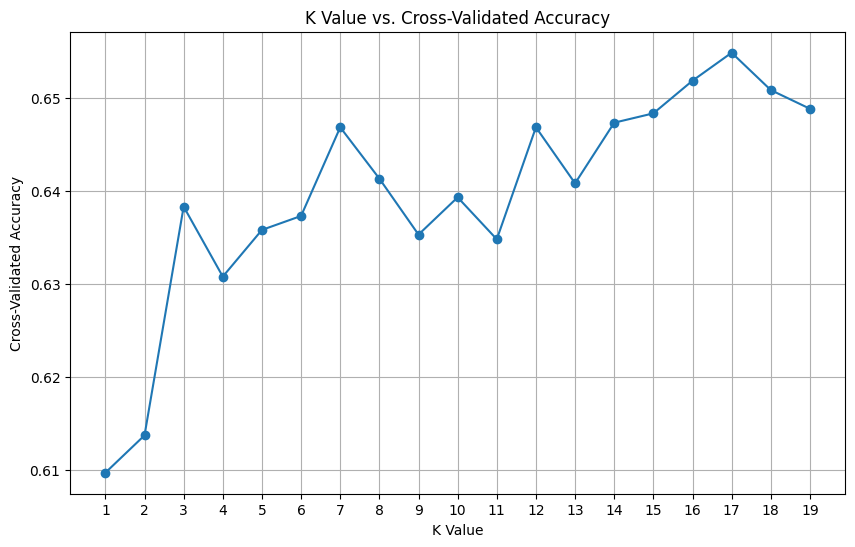

c:\Users\Admin\Desktop\metaverse\project\dog_adopt_probability\.venv\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


ValueError: X has 2 features, but KNeighborsClassifier is expecting 10 features as input.

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# 1. 여러 K 값에 따른 교차 검증 성능 그래프 그리기

# GridSearchCV 결과에서 각 K 값에 대한 평균 교차 검증 점수(정확도) 가져오기
k_range = range(1, 20)
cv_results = grid_search.cv_results_['mean_test_score']

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(k_range, cv_results, marker='o')
plt.title('K Value vs. Cross-Validated Accuracy')
plt.xlabel('K Value')
plt.ylabel('Cross-Validated Accuracy')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# 2. 최적의 K 값을 사용한 KNN 모델의 결정 경계 시각화

# 최적의 K 값 찾기
best_k = grid_search.best_params_['n_neighbors']

# 최적의 K 값을 사용해 모델 재학습
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train_scaled, y_train)

# 결정 경계 시각화를 위한 그리드 생성
x_min, x_max = X_train_scaled[:, 0].min() - 1, X_train_scaled[:, 0].max() + 1
y_min, y_max = X_train_scaled[:, 1].min() - 1, X_train_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# 각 포인트에 대한 예측값 생성
Z = knn_best.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)

# 훈련 데이터와 테스트 데이터 시각화
plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, edgecolor='k', marker='o', label='Training Data')
plt.scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], c=y_test, edgecolor='k', marker='s', label='Test Data', alpha=0.6)

# 그래프 설정
plt.title(f"K-Nearest Neighbors (K={best_k}) Decision Boundary")
plt.xlabel("Feature 1 (scaled)")
plt.ylabel("Feature 2 (scaled)")
plt.legend()
plt.show()


c:\Users\Admin\Desktop\metaverse\project\dog_adopt_probability\.venv\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Admin\Desktop\metaverse\project\dog_adopt_probability\.venv\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Admin\Desktop\metaverse\project\dog_adopt_probability\.venv\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Admin\Desktop\metaverse\project\dog_adopt_probability\.venv\Lib\

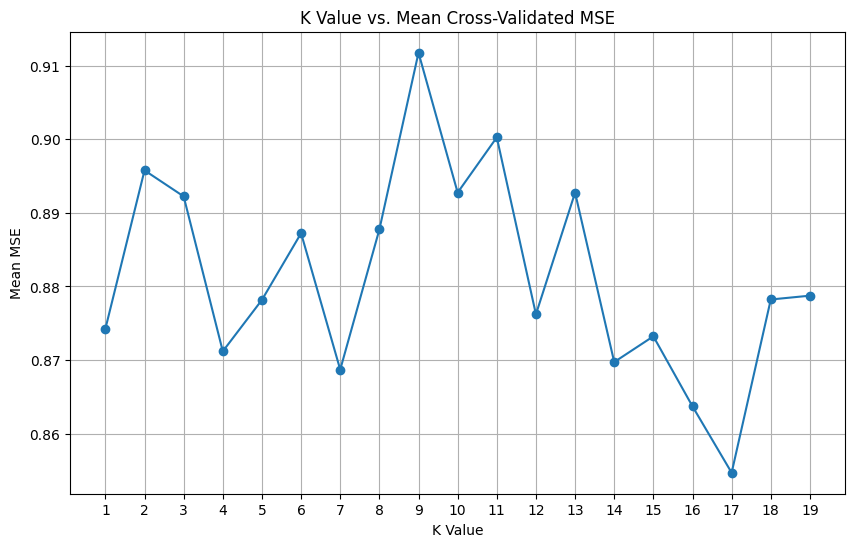

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# K 값 범위 설정
k_range = range(1, 20)
mean_mse_scores = []

# 각 K 값에 대해 교차 검증을 수행하면서 MSE 계산
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # 교차 검증에서 음수 MSE 반환, 이를 양수로 바꿔서 저장
    mse_scores = -cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
    mean_mse_scores.append(mse_scores.mean())

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(k_range, mean_mse_scores, marker='o')
plt.title('K Value vs. Mean Cross-Validated MSE')
plt.xlabel('K Value')
plt.ylabel('Mean MSE')
plt.xticks(k_range)
plt.grid(True)
plt.show()
